# Import Libraries

In [2]:
!pip install fastcluster

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import os
from scipy.cluster.hierarchy import dendrogram
from cuml.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, cophenet, fcluster, dendrogram
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns
import fastcluster


# Data Preprocessing

In [3]:
data = pd.read_csv('..frontend/data/dataset.csv', index_col=0)
data.drop_duplicates(subset='track_id')
features = ['track_name', 'artists', 'popularity', 'track_genre', 'danceability', 'loudness', 'acousticness', 'valence', 'tempo']
X = data[features].copy()
X.drop_duplicates(subset=['track_name', 'artists'], keep='first', inplace=True)
X.reset_index(drop=True, inplace=True)
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['danceability', 'loudness', 'acousticness', 'valence', 'tempo']])

# Define Model Using Euclidean Distance and Average Method




Approximate CCC on subsample: 0.714
Silhouette Score: 0.139


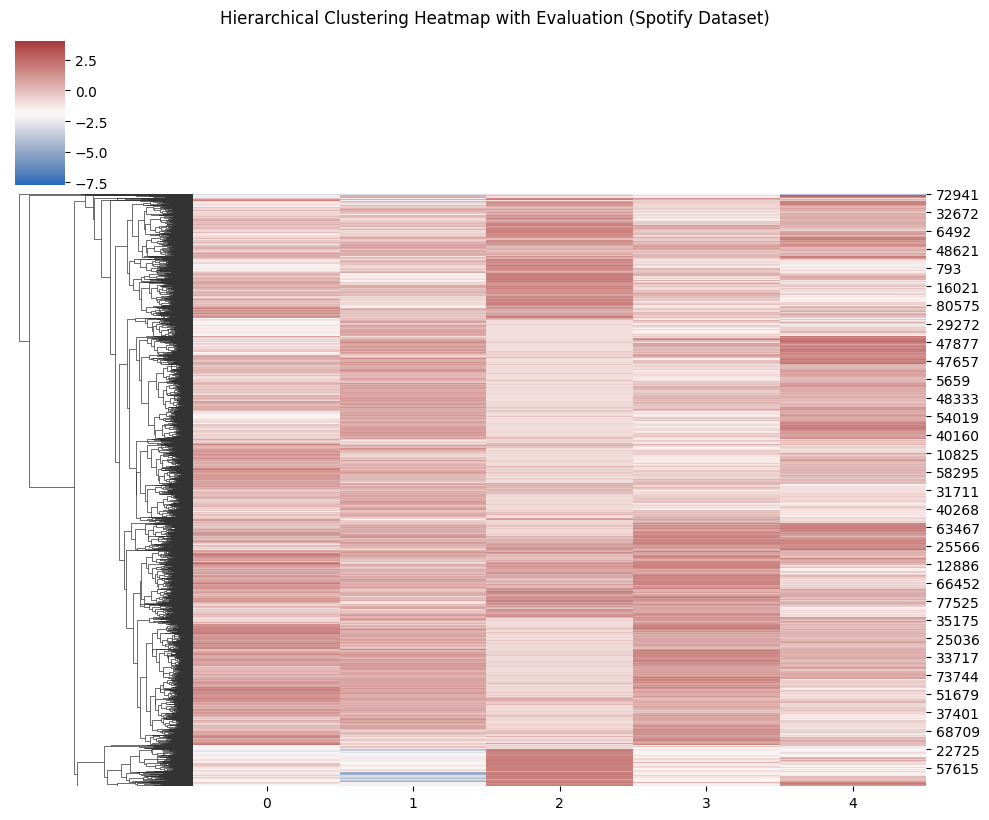

In [12]:

# --- Hierarchical clustering (manual, for evaluation) ---
Z_Euclidean = fastcluster.average(X_scaled)


# Sample 2000 rows
idx = np.random.choice(len(X_scaled), size=2000, replace=False)
Z_subsample = linkage(X_scaled[idx], method='average')
coph_corr, _ = cophenet(Z_subsample, pdist(X_scaled[idx]))

print(f"Approximate CCC on subsample: {coph_corr:.3f}")
# 2. Generate cluster labels by cutting dendrogram
n_clusters = 9
labels_pred_euclidean = fcluster(Z_Euclidean, t=n_clusters, criterion='maxclust')

# 3. Silhouette Score
sil_score = silhouette_score(X_scaled, labels_pred_euclidean)
print(f"Silhouette Score: {sil_score:.3f}")


# --- Visualize clustered heatmap ---
sns.clustermap(
    X_scaled,
    metric='euclidean',
    method='average',
    cmap='vlag',
    figsize=(10, 8),
    row_cluster=True,
    col_cluster=False
)

plt.suptitle("Hierarchical Clustering Heatmap with Evaluation (Spotify Dataset)", y=1.02)
plt.show()



# Define Model Using Correlation Distance and Average Method


Approximate CCC on subsample: 0.427
Silhouette Score: 0.084


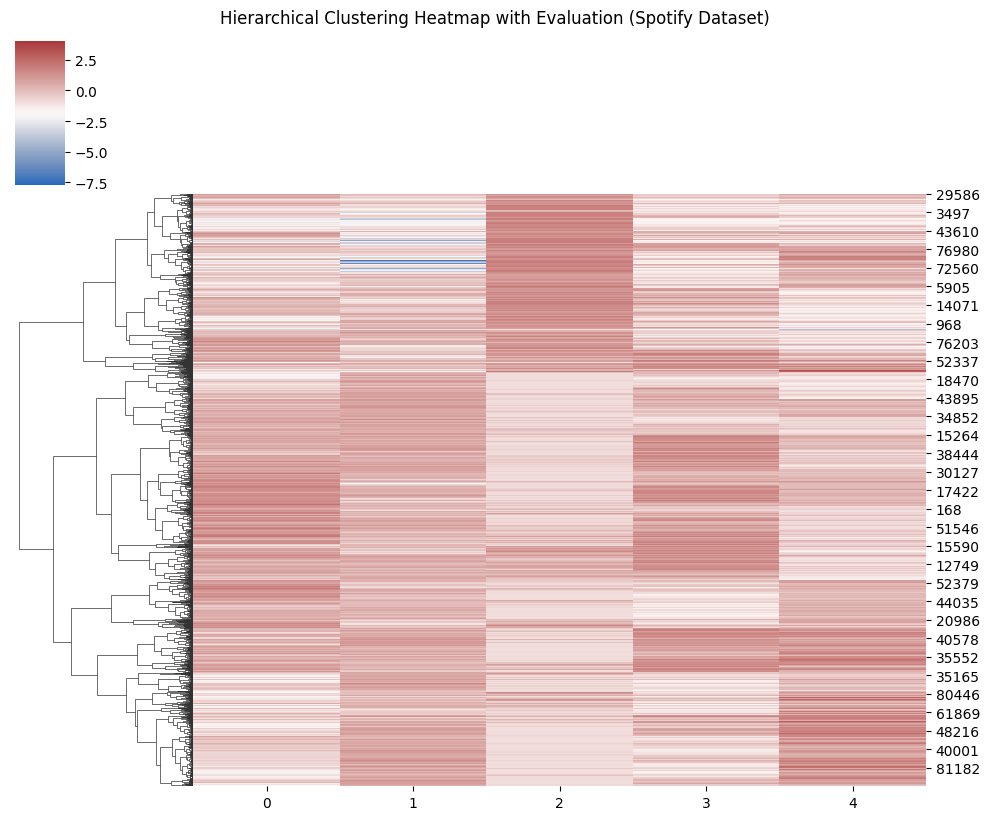

In [4]:

# --- Hierarchical clustering (manual, for evaluation) ---
Z = linkage(X_scaled, method='average', metric='correlation')


# Sample 2000 rows
idx = np.random.choice(len(X_scaled), size=2000, replace=False)
Z_subsample = linkage(X_scaled[idx], method='average',metric='correlation')
coph_corr, _ = cophenet(Z_subsample, pdist(X_scaled[idx]))
print(f"Approximate CCC on subsample: {coph_corr:.3f}")

# 2. Generate cluster labels by cutting dendrogram
n_clusters = 9
labels_pred = fcluster(Z, t=n_clusters, criterion='maxclust')

# 3. Silhouette Score
sil_score = silhouette_score(X_scaled, labels_pred)
print(f"Silhouette Score: {sil_score:.3f}")


# --- Visualize clustered heatmap ---
sns.clustermap(
    X_scaled,
    metric='correlation',
    method='average',
    cmap='vlag',
    figsize=(10, 8),
    row_cluster=True,
    col_cluster=False
)

plt.suptitle("Hierarchical Clustering Heatmap with Evaluation (Spotify Dataset)", y=1.02)
plt.show()



# Define model on Cosine Distance and Average Method

Approximate CCC on subsample: 0.446
Silhouette Score: 0.057


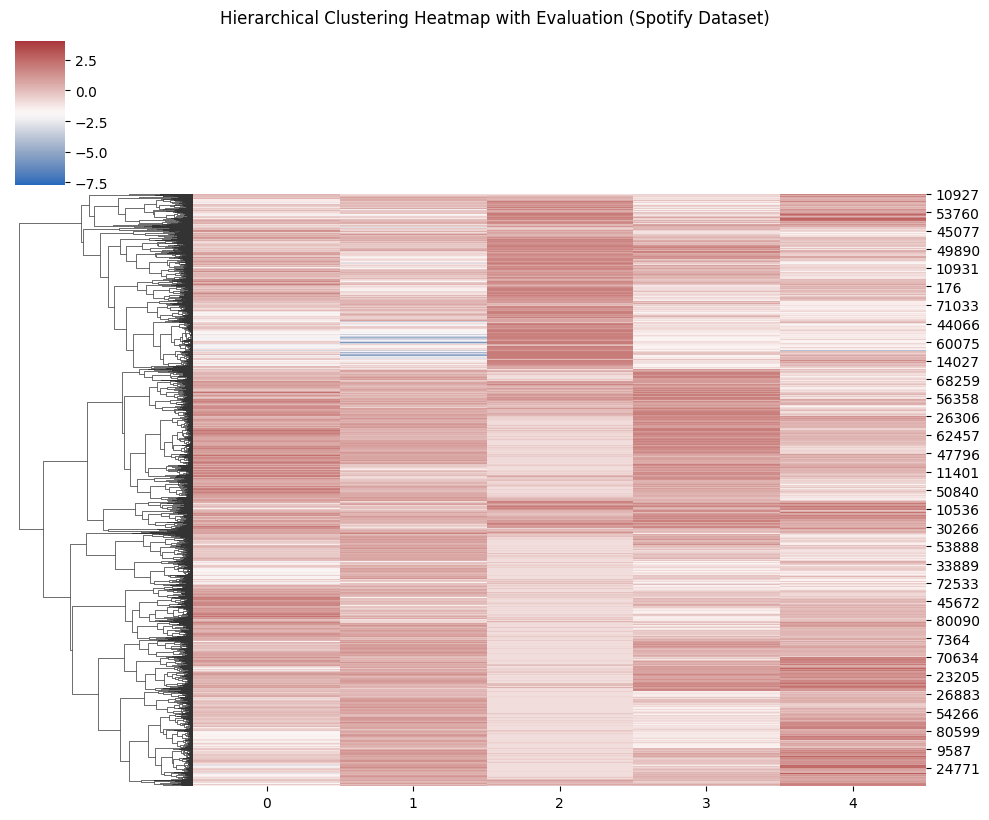

In [13]:
# --- Hierarchical clustering (manual, for evaluation) ---
Z = linkage(X_scaled, method='average', metric='cosine')

# Sample 2000 rows
idx = np.random.choice(len(X_scaled), size=2000, replace=False)
Z_subsample = linkage(X_scaled[idx], method='average',metric='cosine')
coph_corr, _ = cophenet(Z_subsample, pdist(X_scaled[idx]))
print(f"Approximate CCC on subsample: {coph_corr:.3f}")

# 2. Generate cluster labels by cutting dendrogram
n_clusters = 9
labels_pred = fcluster(Z, t=n_clusters, criterion='maxclust')

# 3. Silhouette Score
sil_score = silhouette_score(X_scaled, labels_pred)
print(f"Silhouette Score: {sil_score:.3f}")


# --- Visualize clustered heatmap ---
sns.clustermap(
    X_scaled,
    metric='cosine',
    method='average',
    cmap='vlag',
    figsize=(10, 8),
    row_cluster=True,
    col_cluster=False
)

plt.suptitle("Hierarchical Clustering Heatmap with Evaluation (Spotify Dataset)", y=1.02)
plt.show()



# Result of Different Distance Function and Clustering Method



| Distance Metric                    | Cophenetic Correlation Coefficient | Silhouette Score |
|------------------------------------|------------------------------------|------------------|
| Euclidean Distance + Average       | 0.714                              | 0.139            |
| Correlation Distance + Average     | 0.427                              | 0.084            |
| Cosine Distance + Average          | 0.446                              | 0.057            |

Euclidean distance with average linkage yielded the best clustering performance, showing the highest Cophenetic Correlation (0.714) and Silhouette Score (0.139). This indicates more reliable cluster structure and better separation compared to correlation or cosine distances.

Note: CCC was computed on a 2,000 subsample due to limited computational resources for processing the full 80,000 row dataset.

# Display  Cluster Information

In [22]:
results = X.copy()
results['cluster'] = labels_pred_euclidean.astype(str)
print(results['cluster'].value_counts())


cluster
7    74803
8     5639
5      393
6      350
2      124
1       21
9        7
4        5
3        2
Name: count, dtype: int64


In [23]:
# Make a copy of the data
results = X.copy()

# Add cluster assignments
results['cluster'] = labels_pred_euclidean.astype(str)

# Create a DataFrame to store the top 3 genres per cluster
top_genres_list = []

# Loop over each unique cluster
for cluster_id in sorted(results['cluster'].unique(), key=int):
    top_genres = results[results['cluster'] == cluster_id]['track_genre'].value_counts().head(3)
    row = {
        'Cluster': cluster_id,
        'Genre 1': top_genres.index[0] if len(top_genres) > 0 else '',
        'Count 1': top_genres.iloc[0] if len(top_genres) > 0 else 0,
        'Genre 2': top_genres.index[1] if len(top_genres) > 1 else '',
        'Count 2': top_genres.iloc[1] if len(top_genres) > 1 else 0,
        'Genre 3': top_genres.index[2] if len(top_genres) > 2 else '',
        'Count 3': top_genres.iloc[2] if len(top_genres) > 2 else 0,
    }
    top_genres_list.append(row)

# Convert to DataFrame
real_top_genres_df = pd.DataFrame(top_genres_list)
display(real_top_genres_df)

,Cluster,Genre 1,Count 1,Genre 2,Count 2,Genre 3,Count 3
0,1,sleep,21,,0,,0
1,2,sleep,105,iranian,4,guitar,4
2,3,iranian,1,sleep,1,,0
3,4,iranian,3,hardcore,1,romance,1
4,5,black-metal,92,grindcore,52,iranian,32
5,6,classical,68,guitar,28,romance,24
6,7,study,977,heavy-metal,975,forro,968
7,8,sleep,738,new-age,647,ambient,514
8,9,disney,3,sleep,3,world-music,1


# Create Song Search

In [37]:
title = 'call me maybe'
artist = ''
X[X['track_name'].str.contains(title, na=False, case=False) & X['artists'].str.contains(artist, na=False, case=False)]

,track_name,artists,popularity,track_genre,danceability,loudness,acousticness,valence,tempo
15117,Call Me Maybe (Glee Cast Version),Glee Cast,41,club,0.754,-5.595,0.1140,0.722,120.030
25554,Call Me Maybe,Carly Rae Jepsen,80,electro,0.783,-6.548,0.0114,0.660,120.021
50718,Call Me Maybe,Kids Rock Kidz,16,kids,0.736,-6.875,0.0660,0.610,120.064


# Create Playlist Song Recommendation

In [39]:
playlist = [50201]
results.iloc[playlist]

,track_name,artists,popularity,track_genre,danceability,loudness,acousticness,valence,tempo,cluster
50201,Blue Flame,LE SSERAFIM,75,k-pop,0.781,-3.571,0.0281,0.765,112.045,7


In [40]:
# Get the cluster label of each playlist song
playlist_clusters = results.loc[playlist, 'cluster'].astype(int)

# Determine the majority cluster among the playlist songs
majority_cluster = playlist_clusters.mode().iloc[0]

# Get indices of songs in the same majority cluster
indices = results[results['cluster'].astype(int) == majority_cluster].index

# Compute song_score for each song in that cluster (based on similarity to playlist songs)
song_score = []
for song in indices:
    score = float('inf')
    for liked_song in playlist:
        mse = np.mean((X_scaled[song] - X_scaled[liked_song]) ** 2)
        score = min(score, mse)
    song_score.append(score)

# Select top_k most similar songs
top_k = len(playlist) + 5
song_score = np.array(song_score)
most_similar = np.argpartition(song_score, top_k)[:top_k]

# Retrieve the recommended songs
recommended_songs = results.loc[indices[most_similar]]

Display Current Selection

In [41]:
display(recommended_songs)

,track_name,artists,popularity,track_genre,danceability,loudness,acousticness,valence,tempo,cluster
50201,Blue Flame,LE SSERAFIM,75,k-pop,0.781,-3.571,0.02810,0.765,112.045,7
17307,Take You Dancing,Jason Derulo,78,dance,0.789,-4.248,0.03320,0.753,112.985,7
8889,Back to Flow,Krafty Kuts,13,breakbeat,0.773,-3.973,0.01290,0.734,110.027,7
4125,Always,ENHYPEN,59,anime,0.804,-3.836,0.04660,0.730,110.014,7
64576,Sempre Assim,Jota Quest,44,r-n-b,0.757,-3.960,0.00529,0.725,113.979,7
25112,Light It Up - Remix,Major Lazer;Nyla;Fuse ODG,67,edm,0.747,-3.782,0.03750,0.752,107.991,7
